# kNN Graphs
We are looking for new possibilities on how to generate triplets that do not come from a euclidean space, but still seem realistic enough. One idea would be to use a kNN graph on various datasets (f.e. on a mixture of gaussians).

In [1]:
import sys
sys.path.append("..")
import numpy as np
from data_generation import generate_gmm_data_fixed_means
from sklearn.metrics import pairwise_distances
from questionnaire import Questionnaire
from estimators import OrdinalTangles
from cblearn.embedding import SOE
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from plotting import AltairPlotter
import networkx as nx

In [2]:
def make_nearest_neighbour_adjacency(xs: np.ndarray, k: int) -> np.ndarray:
    """
    Returns an adjacency matrix that where each point is connected to an other
    point if it is among it's k nearest neighbours.

    We use an euclidean distance.
    """
    gram = pairwise_distances(xs)
    adjacency_matrix = np.zeros_like(gram)
    # k+1 because we always have dist 0 to self
    smallest = np.argpartition(gram, k+1, axis=1)[:, :k+1]
    np.put_along_axis(adjacency_matrix, smallest, values=1, axis=1) 
    np.fill_diagonal(adjacency_matrix, 0)
    return adjacency_matrix

In [7]:
seed=10
k = 5
data = generate_gmm_data_fixed_means(n=50, means=np.array([[-6,3], [-6,-3], [6, 3]]), std=2, seed=seed)
nn_adjacency = make_nearest_neighbour_adjacency(data.xs, k)
graph = nx.convert_matrix.from_numpy_matrix(nn_adjacency, parallel_edges=True)
q = Questionnaire.from_graph(graph, density=0.001, seed=seed)

# Tangles
tangles = OrdinalTangles(25)
ys_tangles = tangles.fit_predict(q.values)

# SOE-kMeans
soe = SOE(n_components=2, random_state=seed)
kmeans = KMeans(3)
embedding = soe.fit_transform(*q.to_bool_array())
ys_soe = kmeans.fit_predict(embedding)

Generating questionnaire...
Generating question set...
Filling out questionnaire...


100%|██████████| 150/150 [00:00<00:00, 14848.85it/s]


alt.HConcatChart(...)

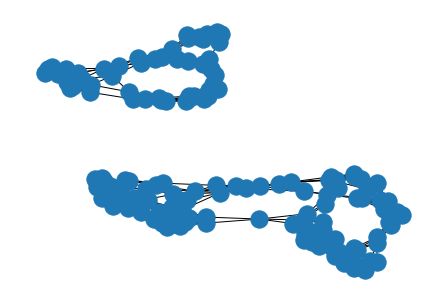

In [19]:
# some visual representations
import matplotlib.pyplot as plt
p = AltairPlotter()
nx.draw(graph)
p.assignments(data.xs, data.ys).properties(title="Original data", width=280, height=240) | p.assignments(embedding, ys_soe).properties(title="Embedding produced by SOE", width=280, height=240)

In the graph, the clusters are not very visible by eye, but we can clearly see in the original data, that the clusters are discernible.

In [20]:
print(f"NMI tangles: {normalized_mutual_info_score(data.ys, ys_tangles)} ({np.unique(ys_tangles).size})")
print(f"NMI SOE: {normalized_mutual_info_score(data.ys, ys_soe)}")

NMI tangles: 0.8622701718997605 (3)
NMI SOE: 0.7055810693277987


This looks very nice, Tangles finds the correct amount of clusters and has a significantly better performance than SOE. Maybe this hints at our original assumption (Tangles might work better on non-euclidean data than comparable methods).